# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import *
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../data/data.csv', index_col=0)

In [3]:
df

,title,label
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


# Preprocessing

In [4]:
# nltk stopwords
stopwords = stopwords.words('english')

In [5]:
import re
import nltk
from nltk import word_tokenize
# Step 1: Lowercasing
df['title'] = df['title'].str.lower()

# Step 2: Removing Punctuation, Numbers, and Special Characters
df['title'] = df['title'].apply(lambda x: re.sub(r'\d+', '', x))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Step 3: Tokenization
df['title'] = df['title'].apply(nltk.word_tokenize)

# Step 4: Removing Stop Words (for French title)
df['title'] = df['title'].apply(
    lambda x: [word for word in x if word not in stopwords])
# Step 5: Stemming (using SnowballStemmer for French)
#stemmer = SnowballStemmer('english')
#df['title'] = df['title'].apply(lambda x: [stemmer.stem(word) for word in x])

# Step 6: Convert tokenized words back to strings
df['title'] = df['title'].apply(' '.join)

In [6]:
# add the var length
df['length'] = df['title'].apply(lambda x: len(x.split()))

# EDA

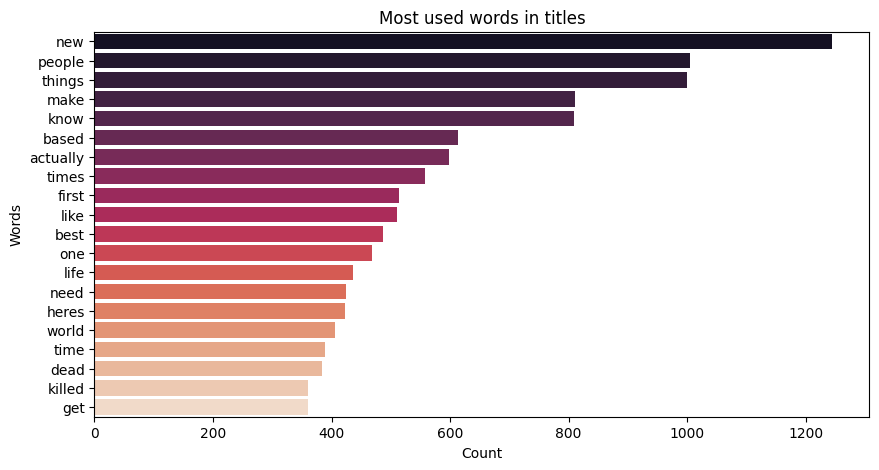

In [7]:
plot_most_used_words(df)

In [9]:
df

,title,label,length
0,get bings,1,2
1,tv female friend group belong,1,5
2,new star wars force awakens trailer give chills,1,8
3,vine new york celebrity big brother fucking pe...,1,8
4,couple stunning photo shoot baby learning inop...,1,9
...,...,...,...
31995,make female hearts flutter iraq throw shoe,0,7
31996,british liberal democrat patsy calton dies cancer,0,7
31997,drone smartphone app help heart attack victims...,0,10
31998,netanyahu urges pope benedict israel denounce ...,0,7


In [12]:
def plot_wordcloud(df, max_words = 200, max_font_size = 40):

    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        scale=3,
        random_state=1).generate(str(df['title']))
    plt.imshow(wordcloud)
    plt.axis('off')

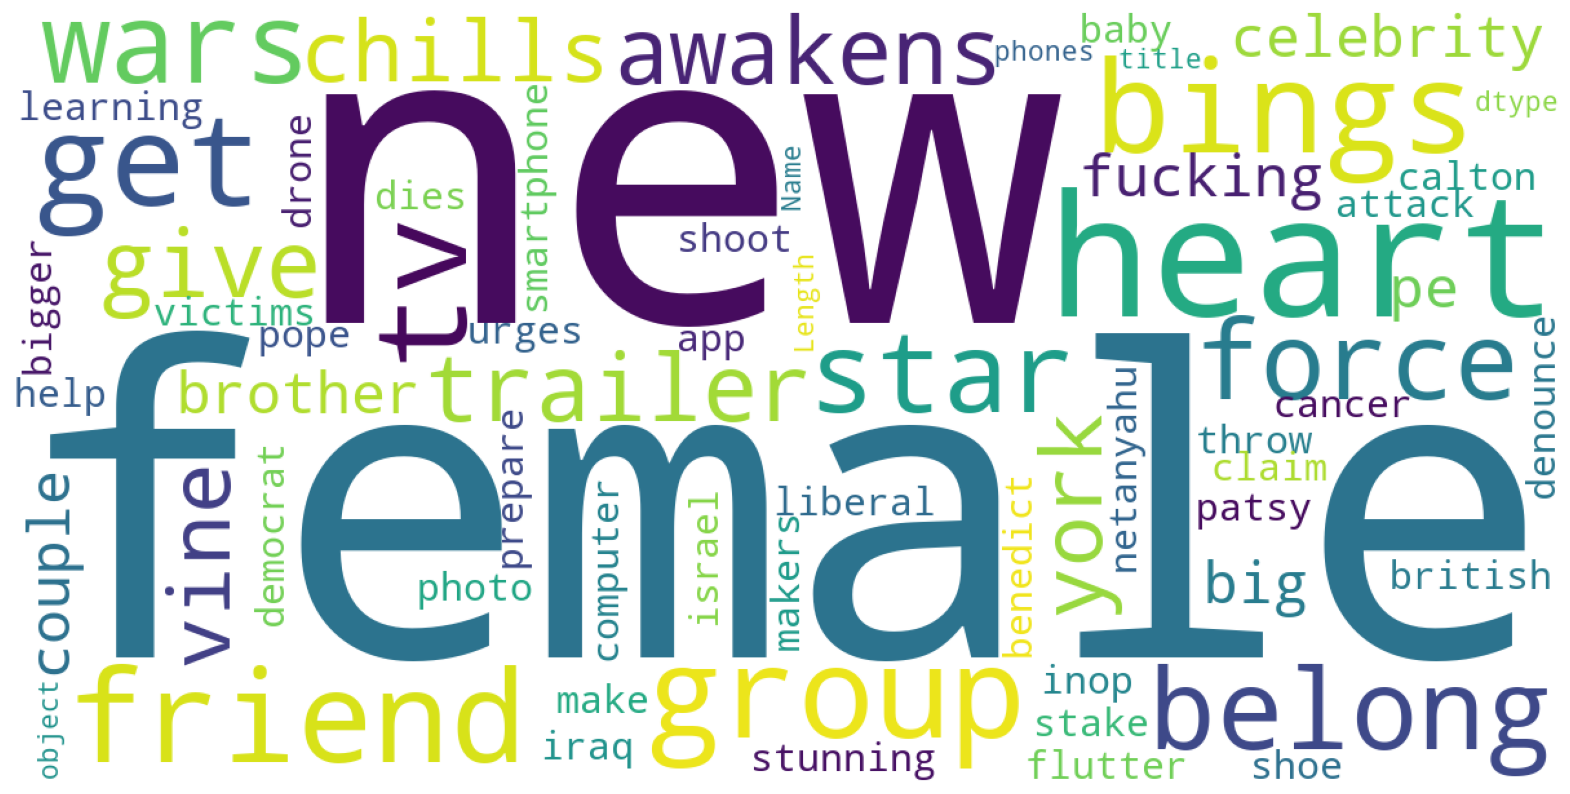

In [13]:
# full data
plot_wordcloud(df)

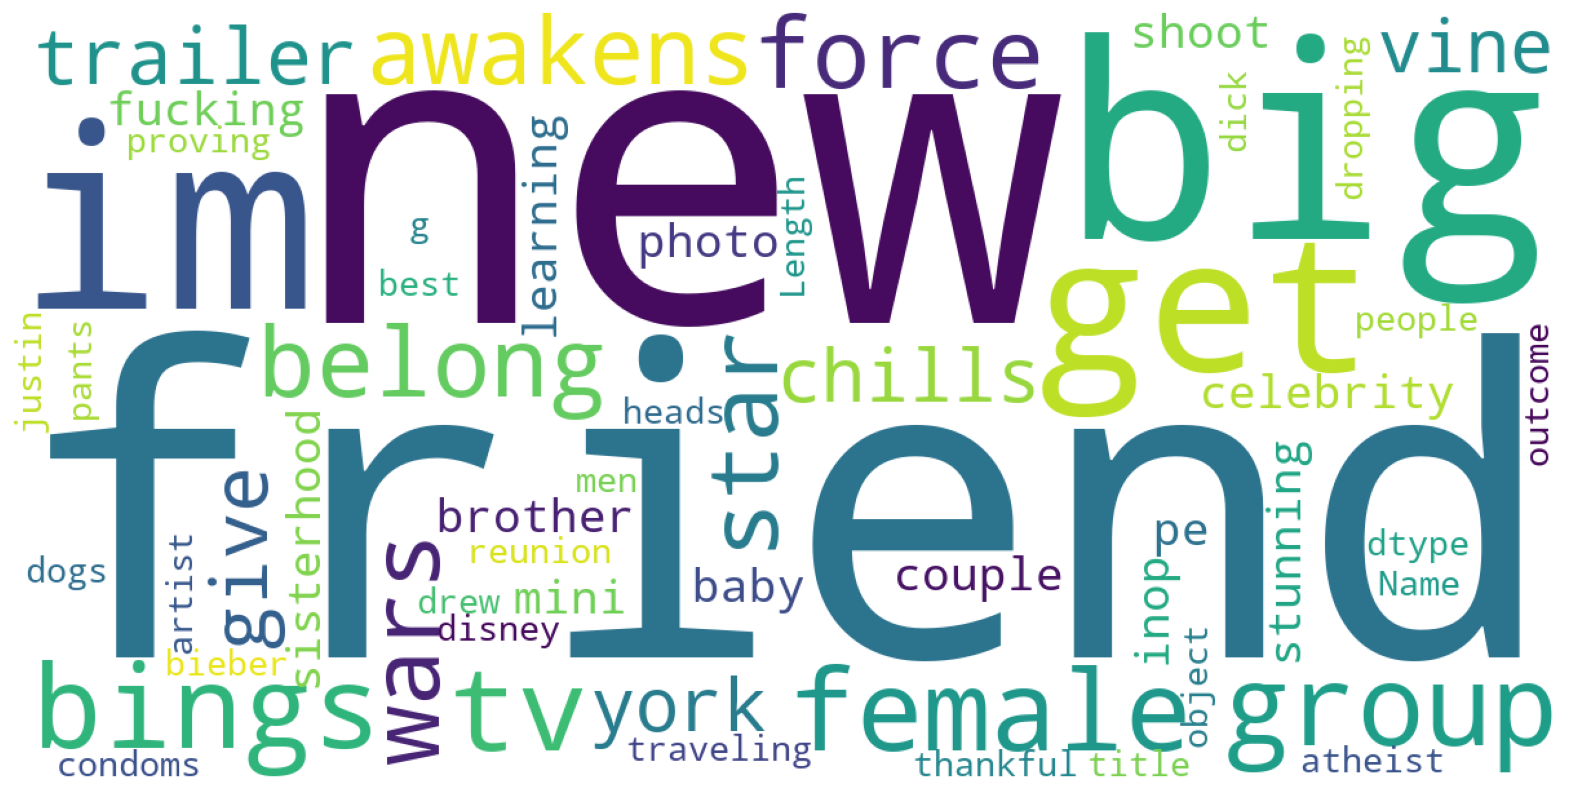

In [13]:
# positive data
plot_wordcloud(df[df['label'] == 1])

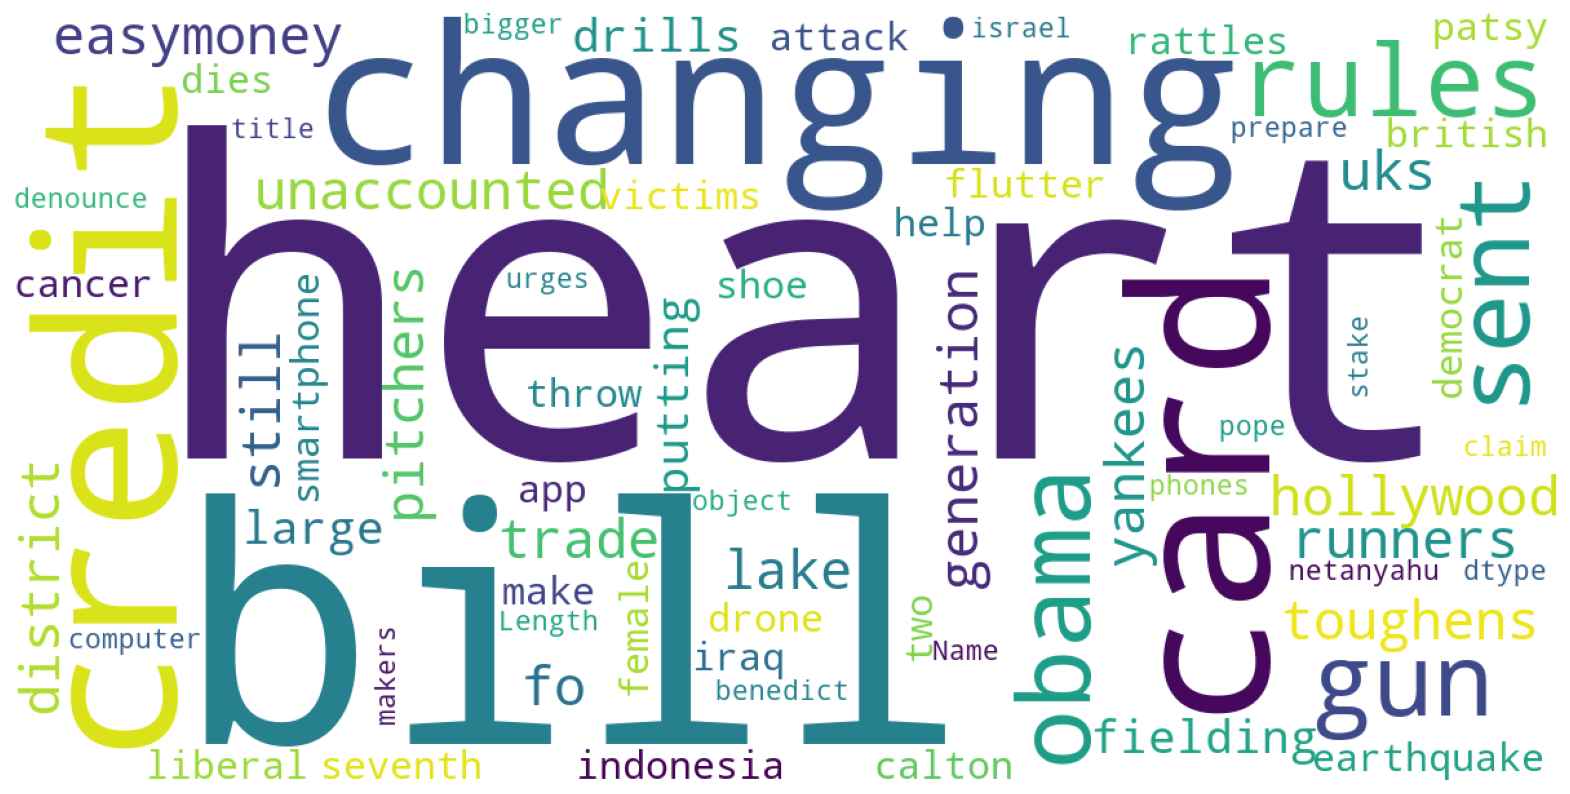

In [14]:
# negative data
plot_wordcloud(df[df['label'] == 0])

c:\Users\ISSAM ECH-CHAOUI\anaconda3\envs\envgpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


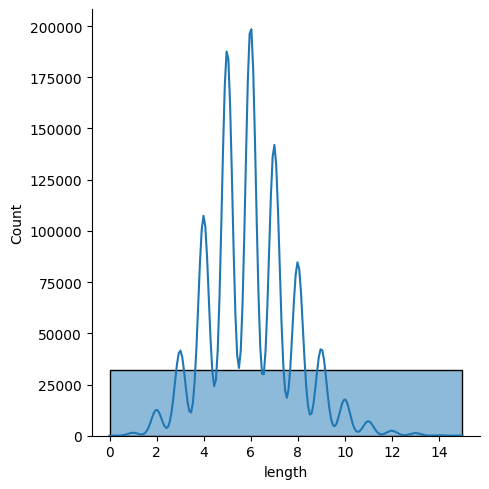

In [8]:
# write the code of plot the distribution of the length of the title with seaborn

def plot_distribution_length(df):
    import seaborn as sns
    sns.displot(df['length'], kde=True, bins=True)
    plt.show()

plot_distribution_length(df)

In [6]:
import pandas as pd
from utils.functions import *
df = pd.read_csv('../data/data.csv')

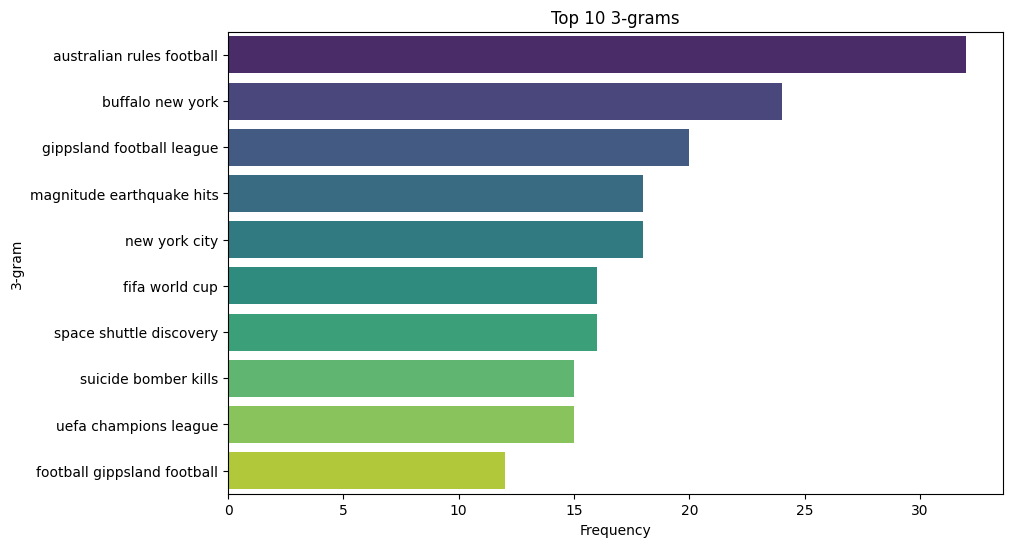

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
plot_most_frequent_ngrams(df[df['label'] == 0],n=3, num_ngrams=10)

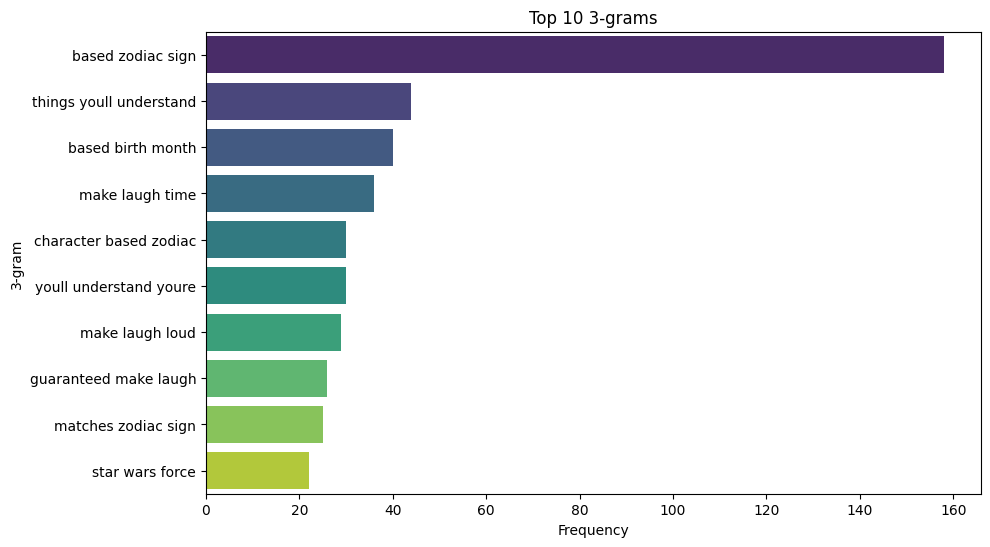

In [15]:
plot_most_frequent_ngrams(df[df['label'] == 1],  n=3, num_ngrams=10)

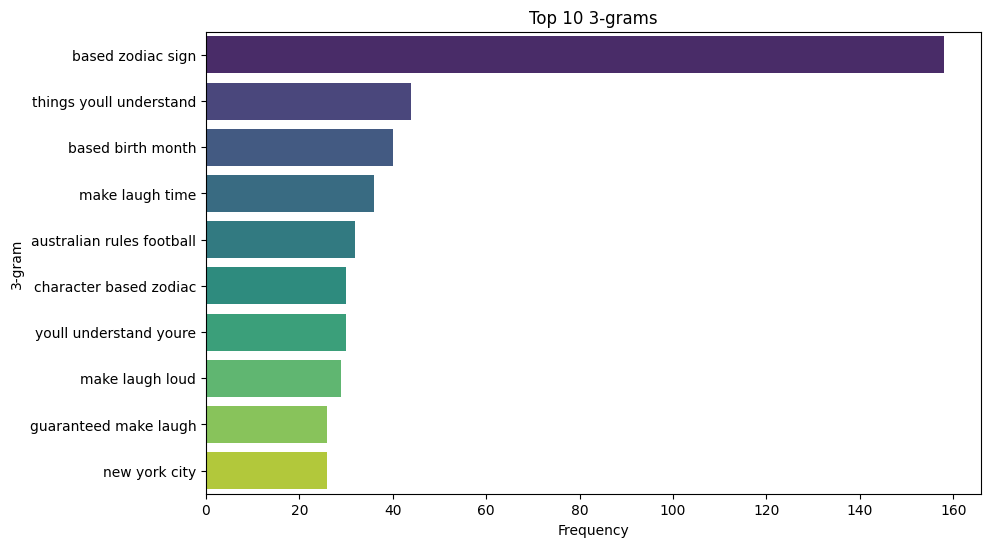

In [16]:
plot_most_frequent_ngrams(df, 'title', n=3, num_ngrams=10)

 *    Noun (NN)- Joseph, London, table, cat, teacher, pen, city

*    Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is

*    Adjective (JJ)- beautiful, happy, sad, young, fun, three

*    Adverb (RB)- slowly, quietly, very, always, never, too, well, tomorrow

*    Preposition (IN)- at, on, in, from, with, near, between, about, under

*    Conjunction (CC)- and, or, but, because, so, yet, unless, since, if

*    Pronoun (PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this

*    Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

# Model

embedding layer -> Turns positive integers (indexes) into dense vectors of fixed size.

e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

In [ ]:
# create a LSTM model 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

# create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

# create sequences
sequences = tokenizer.texts_to_sequences(df['title']) # list of list of int
max_length = 12 # max length of each sequences
embedding_dim = 16 # dimension of the embedding vector
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print(padded_sequences)

# create the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# train the model
num_epochs = 1
history = model.fit(padded_sequences, df['label'], epochs=num_epochs, validation_split=0.2)

# plot the accuracy and loss using model.history
def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()


plot_history(history)

In [28]:
sequences

[[20, 12814],
 [77, 850, 307, 167, 582],
 [2, 55, 159, 303, 896, 641, 135, 7424],
 [2901, 2, 129, 168, 145, 1273, 420, 118],
 [408, 983, 297, 1274, 210, 3932, 12815, 1439, 6270],
 [7425, 2075, 108, 263, 371, 1707, 9246],
 [346, 4, 12816, 593, 247],
 [75, 1107, 308],
 [82, 1014, 2312, 12, 3091, 594],
 [3612, 5443, 6271, 12817, 372, 47, 91, 7426, 8, 224, 1041, 264],
 [118, 2902, 216, 4798],
 [9, 1440, 2186, 362, 1708, 191, 4335],
 [9, 5444, 662, 712, 180],
 [1082, 5, 4336],
 [168, 1977, 7, 33],
 [6272, 233, 25, 139, 126, 691, 204],
 [6273, 265, 12818],
 [102, 2903, 24, 1083, 186, 9247, 3314, 1324, 373],
 [16, 13, 60, 403, 96, 12819],
 [2442, 5, 198],
 [2, 96, 76],
 [3092, 396, 326, 17, 1709, 58, 2443, 475],
 [78, 1, 1648, 9248, 3933],
 [9, 3093],
 [4799, 3094, 1275, 5445, 4337],
 [5446, 3315, 2313, 307],
 [133, 259, 1649, 135, 1441, 1710],
 [379, 435, 713, 273, 5447, 49, 1978],
 [181, 9249, 205],
 [1108, 1015, 211, 146, 47, 536, 7427, 18],
 [3613, 25, 195, 1042],
 [527, 69, 2738, 9250, 5

In [27]:
padded_sequences

array([[   20, 12814,     0, ...,     0,     0,     0],
       [   77,   850,   307, ...,     0,     0,     0],
       [    2,    55,   159, ...,  7424,     0,     0],
       ...,
       [ 2118,  3391,  2262, ...,  5262,  2894,  1130],
       [ 3276,  1789,   652, ...,     0,     0,     0],
       [ 1355,  2310,  2274, ...,     0,     0,     0]])